In [1]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True, return_X_y=True)
df, target = data[0], data[1] 

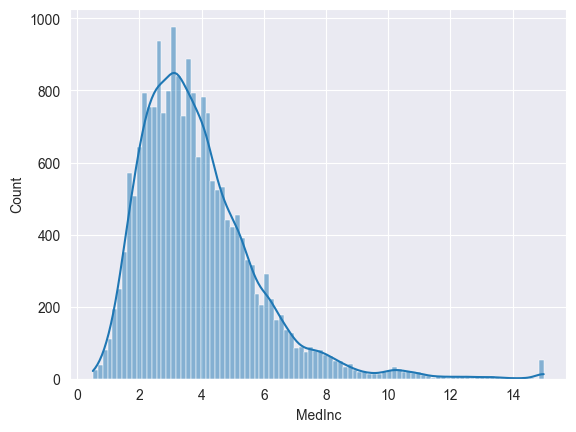

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['MedInc'], kde=True)
plt.show()

Кроме логнормального распределения сюда подходит ещё и гамма-распределение. Давайте найдём параметры распределения под нашу выборку. У него есть два основных параметра, хотя в версии из scipy вводят также сдвиг (loc). Мы его будем полагать равным 0 (тогда носитель распределение, то есть возможные значения — положительные числа), а другие два: a, scale — будем искать. 

Для этого сначала реализуйте функцию, которая будет вычислять логарифм правдоподобия для нашей выборки. Вам понадобится распределения gamma из библиотеки scipy. Функция должна принимать на вход один аргумент, в котором будут расположены все нужные вам параметры. 

Далее воспользуйтесь функцией minimize из модуля optimize библиотеки scipy. Там реализованы методы оптимизации. Укажите вашу функцию для вычисления логарифма правдоподобия, начальное значение ваших параметров и метод L-BFGS-B.

В качестве начального приближения возьмите a=1, scale=2. Если становится сложно, то воспользуйтесь похожим примером из лекции. Имейте в виду, что здесь мы не указываем, как рассчитывается градиент и гессиан (вторая производная) для нашей функции, поэтому они будут рассчитываться численно, что обычно плохо сказывается на процессе оптимизации.

Для проверки нарисуйте на одном графике гистограмму вашей случайной величины и плотность распределения с настроенными параметрами (метод pdf для расчёта плотности, а в качестве точек можно точки с равномерной сетки с помощью np.linspace). Должны получаться похожие картинки.

Какие значения параметров вы получили?

In [5]:
import scipy.stats
import numpy as np

In [20]:
def loglik(theta): #на вход идёт список параметров распределения

    a, scale = theta #раскладываем его на два для удобства

    #считаем логарифм плотности для гамма-распределения
    #x - наши данные, подставьте их туда сразу
    lpdf = scipy.stats.gamma.logpdf(df['MedInc'], a=a, loc=0, scale=scale)

    #считаем лог-правдоподобие для всех значений
    LL = np.sum(lpdf)
    
    #возвращаем с отрицательным знаком 
    #так как дальнейшая функция оптимизирует в сторону уменьшения
    return(-LL)

In [21]:
theta0 = [1,2]

result = scipy.optimize.minimize(loglik, theta0, method='L-BFGS-B')
optimal_params = result.x


print("Оптимальные параметры (a, scale):", optimal_params)

Оптимальные параметры (a, scale): [4.74906248 0.81503914]


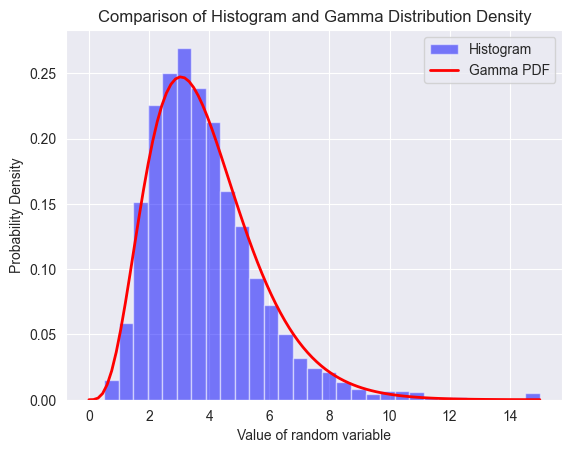

In [22]:
x = np.linspace(0, 15, 100)
pdf_values = scipy.stats.gamma.pdf(x, a=optimal_params[0], loc=0, scale=optimal_params[1])

# Plot histogram of data
plt.hist(df['MedInc'], bins=30, density=True, alpha=0.5, color='blue', label='Histogram')

# Plot density function with optimized parameters
plt.plot(x, pdf_values, 'r-', lw=2, label='Gamma PDF')

plt.xlabel('Value of random variable')
plt.ylabel('Probability Density')
plt.title('Comparison of Histogram and Gamma Distribution Density')
plt.legend()
plt.show()

Посчитайте ядерную оценку плотности в точке x=6 для медианного дохода с помощью sklearn.neighbors.KernelDensity с треугольным (линейным) ядром и h=0.5. Вам понадобятся методы fit (настройка) и score_samples (применение). Учтите, что вам вернутся логарифмы оценки, так что надо от них взять экспоненту.

In [23]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True, return_X_y=True)
df, target = data[0], data[1] 

In [38]:
from sklearn.neighbors import KernelDensity

# Convert DataFrame column to a numpy array and reshape it
data = df['MedInc'].values.reshape(-1, 1)

# Fit Kernel Density Estimation
kde = KernelDensity(kernel='linear', bandwidth=0.5).fit(data)


In [37]:
x = np.array([[6]])  # Преобразование вектора в массив
log_density_x = kde.score_samples(x)

# Взятие экспоненты от логарифма оценки
density_x = np.exp(log_density_x)

print("Оценка плотности в точке x=6:", density_x[0])

Оценка плотности в точке x=6: 0.07392296511627905


Давайте проверим, действительно ли вычисленная по этой формуле величина будет плотностью распределения.

Для этого возьмите настроенную в прошлом задании оценку плотности и убедитесь, что площадь под графиком кривой оценки плотности равна единице. Это и есть условие на функцию, претендующую быть плотностью (аналогично тому, что сумма вероятностей всех возможных исходов должна давать единицу).

Для этого сгенерируйте точки на равномерной сетке с некоторым количеством точек, где левая граница будет немного левее, чем исходная выборка (можно брать с запасом), а правая — наоборот правее исходной выборки, на которой настраивалась оценка в предыдущем задании. Для этого можно построить гистограмму той величины. Для генерации будет полезен метод np.linspace.

Далее посчитайте значение плотности с помощью вашей оценки в каждой сгенерированной точке. Не спешите суммировать — в численной оценке интеграла мы каждый кусочек заменяем на прямоугольник, высота которого равна значению плотности, а ширина — расстоянию между соседними точками. Площадь под графиком будет равно площади этих столбиков. Посчитайте её и сравните с единицей.

Попробуйте разное количество точек (соответственно разное расстояние между соседними точками) — чем уже прямоугольники, тем точнее оценка на интеграл.

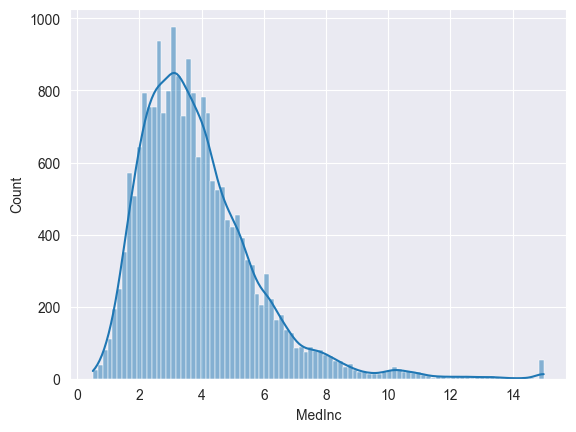

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['MedInc'], kde=True)
plt.show()

In [43]:
x_grid = np.linspace(0.0, 17.0, num=1000)
log_density_grid = kde.score_samples(x_grid.reshape(-1, 1))
density_grid = np.exp(log_density_grid)

# Вычисление площади под кривой плотности методом прямоугольников
area = np.sum(np.diff(x_grid) * density_grid[:-1])

print("Площадь под кривой оценки плотности:", area)

Площадь под кривой оценки плотности: 0.9999987067190943
